<a href="https://colab.research.google.com/github/palakagl/DeepLearning/blob/main/Trash_Classification_SuperCategory_EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Uncomment only for first run
!pip install neptune-client neptune-tensorflow-keras tensorflow

     |████████████████████████████████| 315 kB 4.3 MB/s 
     |████████████████████████████████| 829 kB 77.2 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 181 kB 75.0 MB/s 
     |████████████████████████████████| 132 kB 57.4 MB/s 
     |████████████████████████████████| 79 kB 9.6 MB/s 
     |████████████████████████████████| 8.6 MB 73.1 MB/s 
     |████████████████████████████████| 138 kB 45.3 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 127 kB 59.2 MB/s 
     |████████████████████████████████| 462 kB 48.8 MB/s 
     |████████████████████████████████| 67 kB 7.6 MB/s 
     |████████████████████████████████| 130 kB 53.7 MB/s 
     |████████████████████████████████| 64 kB 2.9 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.15.2-py2.py3-none-any.whl size=565173 sha256=9bdef0acaf137141e5a47f2e4b857629fcf910433a0ca5579b48c4c8c4ddcee5
  Stored in directory: /roo

In [2]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

import cv2
from google.colab.patches import cv2_imshow      # To show images using cv2 module

import pathlib
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.0
Hub version: 0.12.0
GPU is available


In [3]:
# Mount Google drive so dataset can be accessed
from google.colab import drive
drive.mount('/content/drive')
#Path to dataset
DATASET_PATH='/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset/'

Mounted at /content/drive


In [4]:
run = neptune.init(
    project="palakagl/TACO-Dataset",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwYjM0NzcxZi0xYjY1LTRmZWQtOTNmNC1iNjYyNTdkYTBmMWYifQ==",
) 

https://app.neptune.ai/palakagl/TACO-Dataset/e/TAC-27
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


#EDA

/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset//Metal/batch_1_000047.jpg
/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset//Metal/batch_1_000065.JPG
/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset//Paper/batch_1_000008.jpg
/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset//Paper/batch_1_000083.JPG
/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset//Glass/batch_1_000006.jpg
/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset//Glass/batch_1_000013.jpg
/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset//Cigarette/batch_1_000068.JPG
/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset//Cigarette/batch_1_000081.JPG
/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset//Plastic/batch_10_000048.jpg
/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/Final_Dataset//Plastic/batch_10_000016.jpg


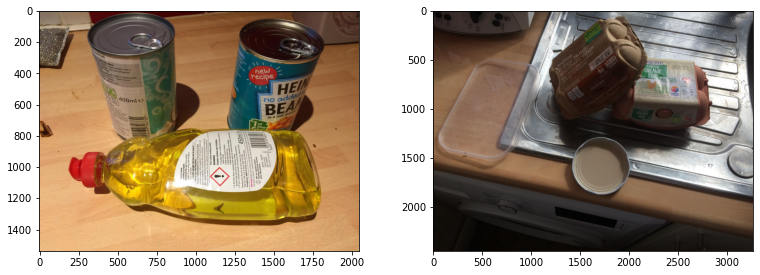

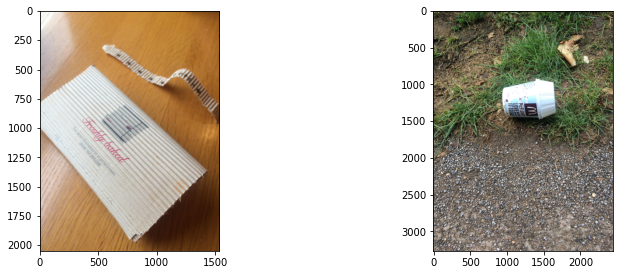

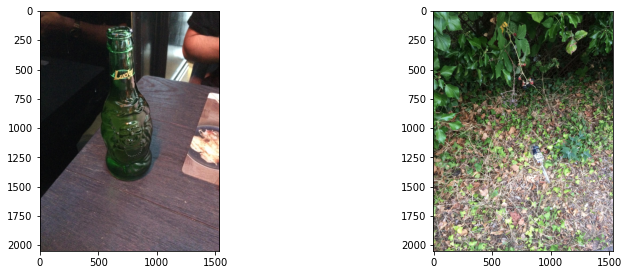

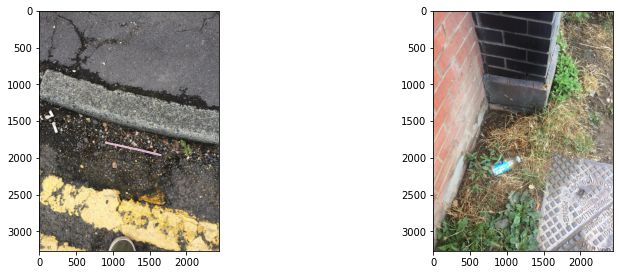

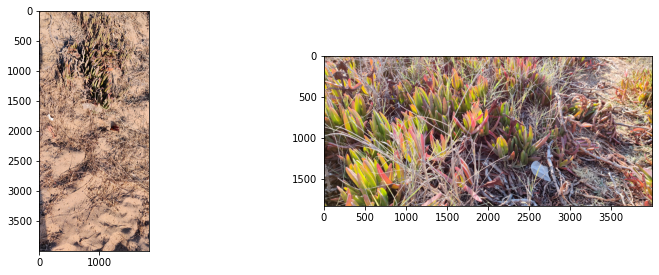

In [5]:
def view_images(datasetpath):
  """
  This function helps to view few random images from dataset
  :param datasetpath: Source dataset path
  :return
  """
  directory=os.listdir(DATASET_PATH)
  for folder in directory:
    plt.figure(figsize=(20,15))
    currentFolder = datasetpath + '/' + folder
    for i, file in enumerate(os.listdir(currentFolder)[0:2]):
        fullpath = currentFolder + "/" + file
        print(fullpath)
        img=plt.imread(fullpath)
        plt.subplot(330 + 1 + i)
        plt.imshow(img)

view_images(datasetpath=DATASET_PATH)

# Data Preparation

In [6]:
#Initialize 
PIXELS = 224#@param {type:"integer"}
BATCH_SIZE = 16#@param {type:"integer"}
IMAGE_SIZE = (PIXELS, PIXELS) 

def load_data(datasetpath, data_params):
  """
  This function load data from source directory and divide it in Train 
  and validation datasets
  :param datasetpath: Source dataset path
  :return VAL_generator, TRAIN_generator:
  """
  data_dir = pathlib.Path(datasetpath) 

  datagen_kwargs = dict(rescale=1./255, 
                        validation_split=0.2)
  dataflow_kwargs = dict(target_size=(PIXELS, PIXELS), 
                        batch_size=BATCH_SIZE,
                        class_mode='categorical',
                        interpolation=data_params['interpolation'],
                        color_mode=data_params['color_mode'])

  valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      **datagen_kwargs)

  valid_generator = valid_datagen.flow_from_directory(
      data_dir, subset="validation", 
      shuffle=data_params['shuffle'], **dataflow_kwargs)
  
  train_datagen = ImageDataGenerator(
            horizontal_flip=data_params['horizontal_flip'], 
            zoom_range=data_params['zoom_range'],
            brightness_range=data_params['brightness_range'],
            vertical_flip=data_params['vertical_flip'],
            #width_shift_range=0.2, 
            #height_shift_range=0.2,
            #rotation_range=180,
            **datagen_kwargs)

  train_generator = train_datagen.flow_from_directory(
          data_dir, subset="training",
          **dataflow_kwargs)

  return valid_generator, train_generator


data_augmentation_params = {     
    "interpolation": "nearest",
    "shuffle": False,
    "horizontal_flip": True,
    "zoom_range": 0.2,
    "color_mode": "rgb",
    "brightness_range": [0.2,1.5],
    "vertical_flip": False,    
    #"width_shift_range":0.3,
    #"height_shift_range":0.25,
    #"rotation_range":160
}
run["model/data_augmentation_params"] = data_augmentation_params
VAL_generator, TRAIN_generator = load_data(datasetpath=DATASET_PATH, data_params=data_augmentation_params)

Found 389 images belonging to 5 classes.
Found 1564 images belonging to 5 classes.


In [7]:
#Log to NeptuneAI
run["model/transferlearning/model_batch_size"] = BATCH_SIZE
run["model/parameters/image_size"] = IMAGE_SIZE

In [8]:
class_names = TRAIN_generator.class_indices.items()
print(class_names)

dict_items([('Cigarette', 0), ('Glass', 1), ('Metal', 2), ('Paper', 3), ('Plastic', 4)])


# Modelling

## Model For Transfer Learning


In [9]:
def base_model_selection(image_size, include_top=False):
  """
  This function initialize the base model to be used for transfer learning
  :param image_size: Input image size
  :param include_top: Whether to include last layer from base model or not
  :return base_model:
  """
  #imports the mobilenet model
  #BASE_MODEL=keras.applications.MobileNetV2(weights='imagenet',
  #                                          include_top=include_top,
  #                                          input_shape=image_size+(3,))
 
  #imports the Efficientnet model
  BASE_MODEL=keras.applications.EfficientNetB7(weights='imagenet',
                                               include_top=include_top,
                                               input_shape=image_size+(3,))
  #imports the Resnet model
  #BASE_MODEL=keras.applications.ResNet50(weights='imagenet',
  #                                       include_top=include_top,
  #                                       input_shape=image_size+(3,))

  run["model/transferlearning/include_top"] = include_top
  return BASE_MODEL
  

#run["model/transferlearning/model_name"] = "ResNet50"
run["model/transferlearning/model_name"] = "EfficientNet"
#run["model/transferlearning/model_name"] = "MobileNetV2"


## Build and Train Model

In [10]:
def build_model(trainable=False, params={}):
  """
  This function build our model with custom layers on top of base model
  :param trainable: If base model layers are trainable
  :param params: Model Hyper Parameters
  :return model:
  """

  BASE_MODEL.trainable = trainable                                      
  
  run["model/transferlearning/base_model_trainable"] = trainable

  inputs = keras.Input(shape=IMAGE_SIZE+(3,))
  x = BASE_MODEL(inputs)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x=Dense(params['dense_units_1'],activation=params['dense_layer_activation_1'])(x)
  x=Dropout(params['dropout_1'])(x)
  x=Dense(params['dense_units_2'],activation=params['dense_layer_activation_2'])(x)
  x=Dropout(params['dropout_2'])(x)
  x = Flatten()(x)
  x=Dense(params['dense_units_2'],activation=params['dense_layer_activation_2'])(x)
  outputs = keras.layers.Dense(TRAIN_generator.num_classes, activation=params['final_layer_activation'])(x)
  
  model = keras.Model(inputs, outputs)

  model.summary()
  return model


params = {
    "dense_units_1": 512,
    "dense_layer_activation_1": "relu",
    "dropout_1": 0.2,    
    "dense_units_2": 256,
    "dense_layer_activation_2": "relu",
    "dropout_2": 0.1,
    "final_layer_activation": "softmax",
    "learning_rate": 3e-2,
    "n_epochs": 5,    
    "regularizer_rate":0.005
}
run["model/parameters"] = params

BASE_MODEL = base_model_selection(IMAGE_SIZE, include_top=False)
model = build_model(trainable=False, params=params)

258088960/258076736 [==============================] - 8s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               13132

In [11]:
def compile_model(model, params={}):
  """
  This function compile model with setting up different hyper parameters
  :param model: Model which already initialized
  :param params: Model Hyper Parameters
  :return model:
  """
  model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=params['learning_rate'], momentum=0.8), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])
  return model

model = compile_model(model, params)

In [12]:
def train_model(model, params={}):
  """
  This function is used for training the model
  :param model: Model which already initialized
  :param params: Model Hyper Parameters
  :return model:
  """
  steps_per_epoch = TRAIN_generator.samples // TRAIN_generator.batch_size
  validation_steps = VAL_generator.samples // VAL_generator.batch_size

  # Add Callbacks

  # Model Checkpoint
  tl_checkpoint_1 = ModelCheckpoint(filepath = '/content/drive/MyDrive/content/drive/MyDrive/MMAI_894/Model/MobileNet_best_weights.hdf5', save_best_only = True, verbose = 1)

  # Early Stopping Checkpoint
  EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

  history = model.fit(
    TRAIN_generator,
    epochs=params['n_epochs'], steps_per_epoch=steps_per_epoch,
    validation_data = VAL_generator,
    validation_steps = validation_steps,
    callbacks=[NeptuneCallback(run=run), EarlyStoppingCallback]).history
  
  return model, history

model, history = train_model(model, params)


Epoch 1/5
97/97 [==============================] - 1725s 18s/step - loss: 1.3901 - accuracy: 0.5426 - val_loss: 1.3557 - val_accuracy: 0.5443
Epoch 2/5
97/97 [==============================] - 242s 3s/step - loss: 1.3531 - accuracy: 0.5491 - val_loss: 1.3585 - val_accuracy: 0.5443
Epoch 3/5
97/97 [==============================] - 240s 2s/step - loss: 1.3501 - accuracy: 0.5517 - val_loss: 1.3549 - val_accuracy: 0.5443
Epoch 4/5
97/97 [==============================] - 242s 2s/step - loss: 1.3500 - accuracy: 0.5504 - val_loss: 1.3517 - val_accuracy: 0.5443
Epoch 5/5
97/97 [==============================] - 242s 3s/step - loss: 1.3545 - accuracy: 0.5459 - val_loss: 1.3503 - val_accuracy: 0.5443


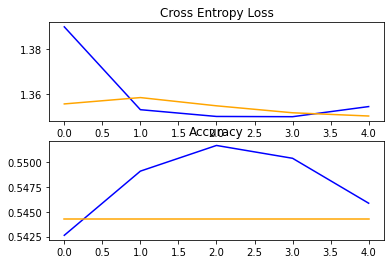

In [13]:
# plot diagnostic learning curves
def result_visualization(history):
  # plot loss
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history['loss'], color='blue', label='train')
  plt.plot(history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(212)
  plt.title('Accuracy')
  plt.plot(history['accuracy'], color='blue', label='train')
  plt.plot(history['val_accuracy'], color='orange', label='test')
  return

result_visualization(history)

In [14]:
'''
# Generate predictions
model.load_weights('/content/drive/MyDrive/content/drive/MyDrive/MMAI_894/Models/MobileNet_best_weights.hdf5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)
'''

"\n# Generate predictions\nmodel.load_weights('/content/drive/MyDrive/content/drive/MyDrive/MMAI_894/Models/MobileNet_best_weights.hdf5') # initialize the best trained weights\npreds = model.predict(test_ds)\npred_classes = np.argmax(preds, axis = 1)\n"

# Save Model

In [15]:
saved_model_path = "/content/drive/MyDrive/content/drive/MyDrive/MMAI_894/Model"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/content/drive/MyDrive/MMAI_894/Model/assets


# Fine Tuning

In [16]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
def fine_tuning_model(trainable):
  BASE_MODEL.trainable = True
  model.summary()

  learning_rate = 1e-4
  epochs = 10

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate),  # Low learning rate
      loss=keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy'],
  )

  history = model.fit(
    TRAIN_generator,
    epochs=epochs,
    validation_data = VAL_generator,
    callbacks=[NeptuneCallback(run=run)]).history

  run["model/fine-tuning/transferlearning/base_model_trainable"] = trainable
  run["model/fine-tuning/parameters/epochs"] = params['n_epochs']  
  run["model/fine-tuning/parameters/learning_rate"] = learning_rate  

  return model, history

fine_tuned_model, fine_tuned_history = fine_tuning_model(trainable=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

#Predictions

In [17]:
def make_prediction(filename):

  class_names = TRAIN_generator.class_indices.items()
  print(class_names)
  
  img = tf.keras.preprocessing.image.load_img(
      filename, target_size=(224, 224)
  )
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  print(predictions)
  score = tf.nn.sigmoid(predictions[0])
  print(score)
  print(list(class_names))
  print( "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(list(class_names)[np.argmax(score)], 100 * np.max(score)) )
  return

FILE_NAME = '/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/trash-test/cigarettebutt (10).jpg'
make_prediction(FILE_NAME)

FILE_NAME = '/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/trash-test/glass 1015.jpg'
make_prediction(FILE_NAME)

FILE_NAME = '/content/drive/MyDrive/MMAI_894/TACO_Dataset/data/trash-test/paper 1010.jpg'
make_prediction(FILE_NAME)

dict_items([('Cigarette', 0), ('Glass', 1), ('Metal', 2), ('Paper', 3), ('Plastic', 4)])
[[4.9916218e-16 0.0000000e+00 4.9171631e-22 1.7418646e-08 1.0000000e+00]]
tf.Tensor([0.5        0.5        0.5        0.5        0.73105854], shape=(5,), dtype=float32)
[('Cigarette', 0), ('Glass', 1), ('Metal', 2), ('Paper', 3), ('Plastic', 4)]
This image most likely belongs to ('Plastic', 4) with a 73.11 percent confidence.
dict_items([('Cigarette', 0), ('Glass', 1), ('Metal', 2), ('Paper', 3), ('Plastic', 4)])
[[2.5375347e-17 9.3993046e-28 2.0386834e-07 4.4858784e-15 9.9999976e-01]]
tf.Tensor([0.5        0.5        0.50000006 0.5        0.7310585 ], shape=(5,), dtype=float32)
[('Cigarette', 0), ('Glass', 1), ('Metal', 2), ('Paper', 3), ('Plastic', 4)]
This image most likely belongs to ('Plastic', 4) with a 73.11 percent confidence.
dict_items([('Cigarette', 0), ('Glass', 1), ('Metal', 2), ('Paper', 3), ('Plastic', 4)])
[[0.08370795 0.00761723 0.09172592 0.18248984 0.634459  ]]
tf.Tensor([0.52091